In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import inspect
import os
import pandas as pd

In [3]:
metadata_camera_parameters_csv_file = os.path.join("..", "metadata_camera_parameters.csv")

#
# we use ai_037_002 as our test scene because it has an especially unusual
# projection matrix and makes use of the the following non-standard lens
# parameters in V-Ray:
# 
# horizontal_offset = 0.06
# horizontal_shift  = 0.0
# lens_shift        = -0.009
# vertical_offset   = -0.08
#

scene_name  = "ai_037_002"
camera_name = "cam_00"
frame_id    = 0

# project all "sofa" vertices into our image
si = 6

camera_dir = os.path.join(scene_name, "_detail", camera_name)
img_dir    = os.path.join(scene_name, "images")

# we need access to the Hypersim meshes in order to execute parts of this notebook
mesh_dir = "/Volumes/lacie/hypersim/evermotion_dataset/scenes/" + scene_name + "/_detail/mesh"

In [4]:
#
# read parameters from csv file
#

df_camera_parameters = pd.read_csv(metadata_camera_parameters_csv_file, index_col="scene_name")

df_ = df_camera_parameters.loc[scene_name]

width_pixels  = int(df_["settings_output_img_width"])
height_pixels = int(df_["settings_output_img_height"])

M_proj = matrix([[ df_["M_proj_00"], df_["M_proj_01"], df_["M_proj_02"], df_["M_proj_03"] ],
                 [ df_["M_proj_10"], df_["M_proj_11"], df_["M_proj_12"], df_["M_proj_13"] ],
                 [ df_["M_proj_20"], df_["M_proj_21"], df_["M_proj_22"], df_["M_proj_23"] ],
                 [ df_["M_proj_30"], df_["M_proj_31"], df_["M_proj_32"], df_["M_proj_33"] ]])

In [5]:
#
# retrieve all vertices belonging to a particular semantic ID
#

mesh_vertices_hdf5_file   = os.path.join(mesh_dir, "mesh_vertices.hdf5")
mesh_faces_vi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_vi.hdf5")
mesh_faces_oi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_oi.hdf5")
mesh_objects_si_hdf5_file = os.path.join(mesh_dir, "mesh_objects_si.hdf5")

with h5py.File(mesh_vertices_hdf5_file,   "r") as f: mesh_vertices   = f["dataset"][:]
with h5py.File(mesh_faces_vi_hdf5_file,   "r") as f: mesh_faces_vi   = f["dataset"][:]
with h5py.File(mesh_faces_oi_hdf5_file,   "r") as f: mesh_faces_oi   = f["dataset"][:]
with h5py.File(mesh_objects_si_hdf5_file, "r") as f: mesh_objects_si = f["dataset"][:]

fi_si = where(in1d(mesh_faces_oi, where(mesh_objects_si == si)[0]))[0]
assert fi_si.shape[0] > 0

mesh_faces_vi_si = mesh_faces_vi[fi_si]
mesh_vertices_si_ = mesh_vertices[mesh_faces_vi_si.ravel()]

mesh_positions_world = mesh_vertices_si_

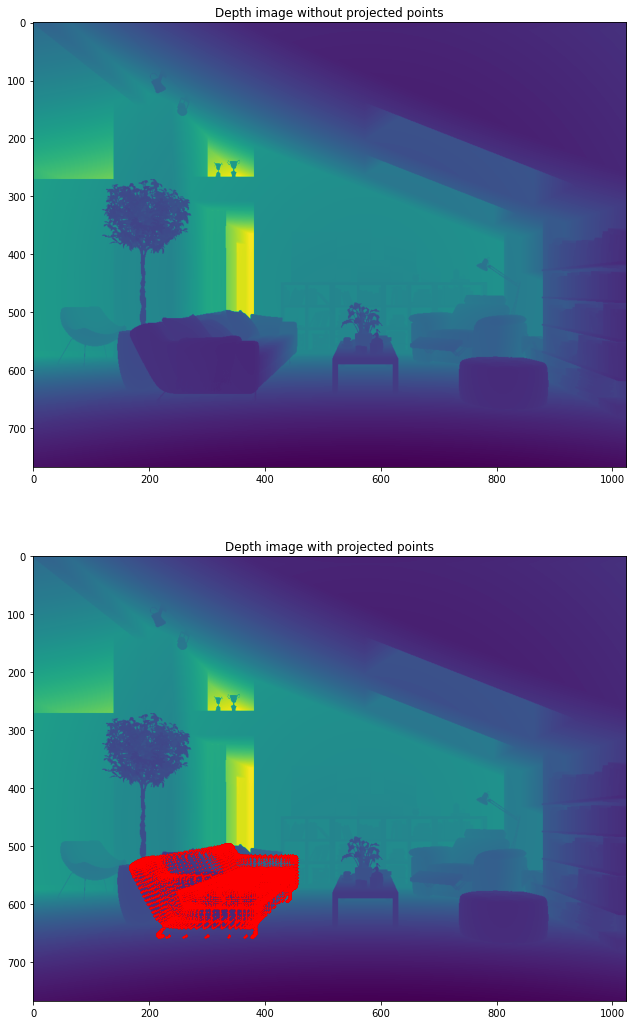

In [6]:
#
# verify that we are projecting points to their correct screen-space positions
#

camera_positions_hdf5_file    = os.path.join(camera_dir, "camera_keyframe_positions.hdf5")
camera_orientations_hdf5_file = os.path.join(camera_dir, "camera_keyframe_orientations.hdf5")

depth_meters_hdf5_file = os.path.join(img_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.%04d.depth_meters.hdf5" % frame_id)

with h5py.File(camera_positions_hdf5_file,    "r") as f: camera_positions    = f["dataset"][:]
with h5py.File(camera_orientations_hdf5_file, "r") as f: camera_orientations = f["dataset"][:]

with h5py.File(depth_meters_hdf5_file, "r") as f: depth_meters = f["dataset"][:].astype(float32)

# matrix to map to integer screen coordinates from normalized device coordinates
M_screen_from_ndc = matrix([[0.5*(width_pixels-1), 0,                      0,   0.5*(width_pixels-1)],
                            [0,                    -0.5*(height_pixels-1), 0,   0.5*(height_pixels-1)],
                            [0,                    0,                      0.5, 0.5],
                            [0,                    0,                      0,   1.0]])

# get position and rotation matrix for Hypersim image
camera_position_world = camera_positions[frame_id]
R_world_from_cam      = camera_orientations[frame_id]

t_world_from_cam = matrix(camera_position_world).T
R_cam_from_world = matrix(R_world_from_cam).T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

M_cam_from_world = matrix(block([[R_cam_from_world, t_cam_from_world],
                                 [matrix(zeros(3)), 1.0]]))

num_points = mesh_positions_world.shape[0]

P_world  = matrix( c_[ mesh_positions_world, ones(num_points) ] ).T
P_cam    = M_cam_from_world*P_world
P_clip   = M_proj*P_cam
P_ndc    = matrix(P_clip.A/P_clip.A[3])
P_screen = M_screen_from_ndc*P_ndc

figsize(18,18)

subplot(211)
imshow(depth_meters)
title("Depth image without projected points")

subplot(212)
imshow(depth_meters)
title("Depth image with projected points")
scatter(P_screen[0].A1, P_screen[1].A1, color="red", s=0.05);
